# The EuRoC MAV Dataset

- [website](https://projects.asl.ethz.ch/datasets/doku.php?id=kmavvisualinertialdatasets)
- [report](https://www.researchgate.net/publication/291954561_The_EuRoC_micro_aerial_vehicle_datasets)

![](https://projects.asl.ethz.ch/datasets/lib/exe/fetch.php?cache=&media=platform.jpg)

![](https://projects.asl.ethz.ch/datasets/lib/exe/fetch.php?cache=&media=sensor_setup2.png)

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [640]:
import numpy as np

import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # set default figure width

import imageio
import attr
from slurm import storage
from pprint import pprint
from pathlib import Path
from math import sqrt

In [641]:
mavfiles = list(Path.home().joinpath("tmp/mav/mav0/cam0/data/").glob("*.png"))
print(f">> Found {len(mavfiles)} images")

>> Found 2912 images


In [642]:
imgfile = mavfiles[2000]
print(f">> Reading: {imgfile}")
im = imageio.imread(imgfile)

>> Reading: /Users/kevin/tmp/mav/mav0/cam0/data/1403715370712143104.png


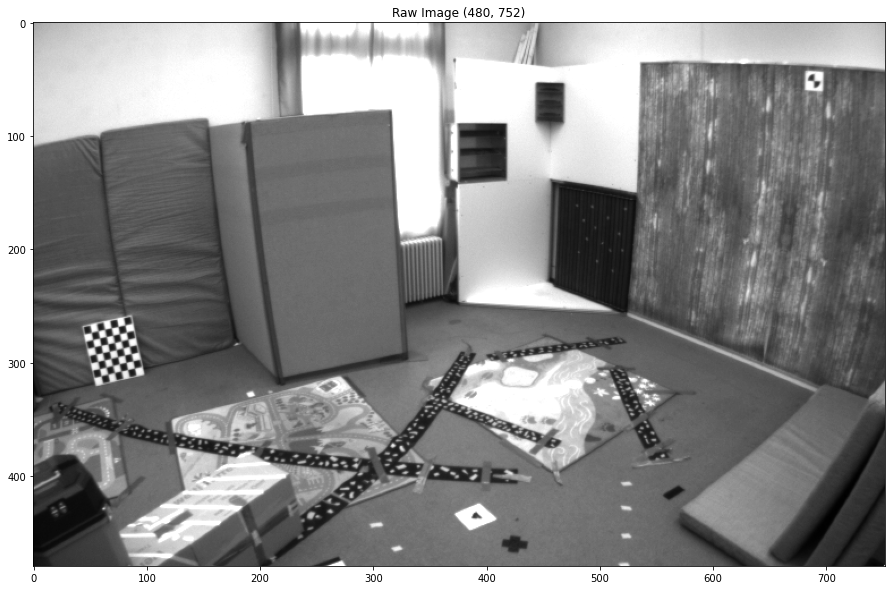

In [643]:
plt.imshow(im, cmap="gray")
plt.title(f"Raw Image {im.shape}");

In [644]:
class Undistort:
    def __init__(self, camMat, dist, w, h):
        self.camMat = camMat
        self.dist = dist
        self.size = (w,h)
        self.optCamMat, _ = cv2.getOptimalNewCameraMatrix(camMat, dist, self.size, 0)
        
    def undistort(self, image, alpha=None):
        """
        image: an image
        mtx: camera matrix
        dist: distortion coefficients
        alpha = 0: returns undistored image with minimum unwanted pixels (image
                    pixels at corners/edges could be missing)
        alpha = 1: retains all image pixels but there will be black to make up
                    for warped image correction
        """
        # Adjust the calibrations matrix
        if alpha is not None:
            self.optCamMat, _ = cv2.getOptimalNewCameraMatrix(
                self.camMat,
                self.dist,
                self.size,
                alpha
            )
        # undistort
        return cv2.undistort(image, self.camMat, self.dist, None, self.optCamMat)

In [672]:
def makeUndistort(num):
    model = storage.read(str(Path.home() / f"tmp/mav/mav0/cam{num}/sensor.yaml"))
    T = np.array(model["T_BS"]["data"]).reshape((4,4))
    w,h = model["resolution"]
    fx,fy,cx,cy = model["intrinsics"]
    cm = np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ])
    
    # print(f">> focal length: {sqrt(fx**2 + fy**2)}")
    
    dist = np.array(model["distortion_coefficients"])
    ud = Undistort(
        cm,
        dist,
        w,h)
    
    return ud, T, cm, dist

In [673]:
# left camera
ud0, T0, cm0, dist0 = makeUndistort(0)
print(T0)

[[ 0.01486554 -0.99988093  0.0041403  -0.02164015]
 [ 0.99955725  0.01496721  0.02571553 -0.06467699]
 [-0.02577444  0.00375619  0.99966073  0.00981073]
 [ 0.          0.          0.          1.        ]]


In [674]:
# right camera
ud1, T1, cm1,dist1 = makeUndistort(1)
print(T1)

[[ 0.01255527 -0.9997551   0.01822377 -0.01984356]
 [ 0.99959878  0.01301191  0.02515884  0.04536894]
 [-0.0253898   0.01790058  0.99951735  0.00786212]
 [ 0.          0.          0.          1.        ]]


In [648]:
baseline = T1[1,3] - T0[1,3]
print(f">> Baseline: {baseline:.3f} m")
print((T1[:3,3] - T0[:3,3])*1000)

>> Baseline: 0.110 m
[  1.79658754 110.04592927  -1.94860612]


In [691]:
h,w = imgL.shape[:2]
_,_,pro0,pro1,qq,roi0,roi1 = cv2.stereoRectify(
    cm0,
    dist0,
    cm1,
    dist1,
    (w, h),
    np.eye(3),
    T1[:3,3] - T0[:3,3],
    flags=cv2.CALIB_ZERO_DISPARITY
)
print(qq)

[[   1.            0.            0.         -372.07770157]
 [   0.            1.            0.         -272.28400803]
 [   0.            0.            0.          458.1205    ]
 [   0.            0.           -9.0844804     0.        ]]
4


In [683]:
# help(cv2.stereoRectify)

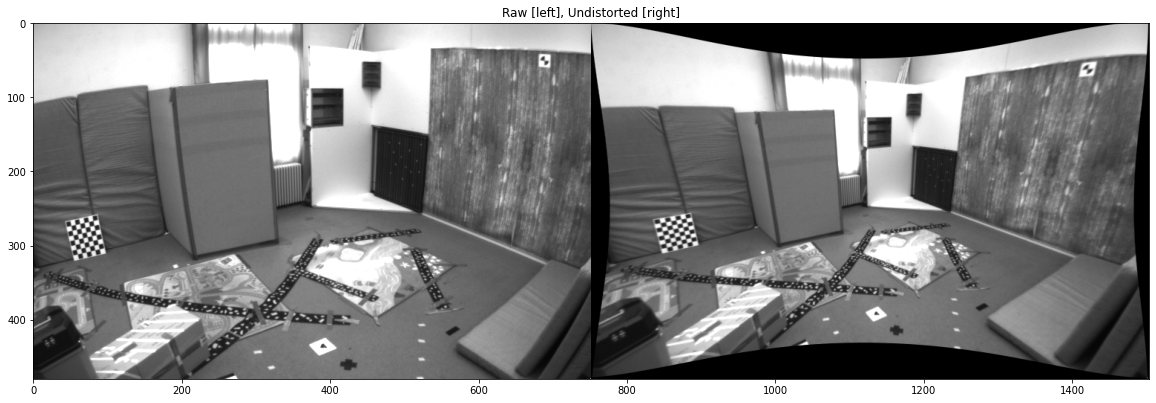

In [652]:
img = ud0.undistort(im,1)
sbs = np.hstack((im,img))
plt.imshow(sbs, cmap="gray")
plt.title("Raw [left], Undistorted [right]");

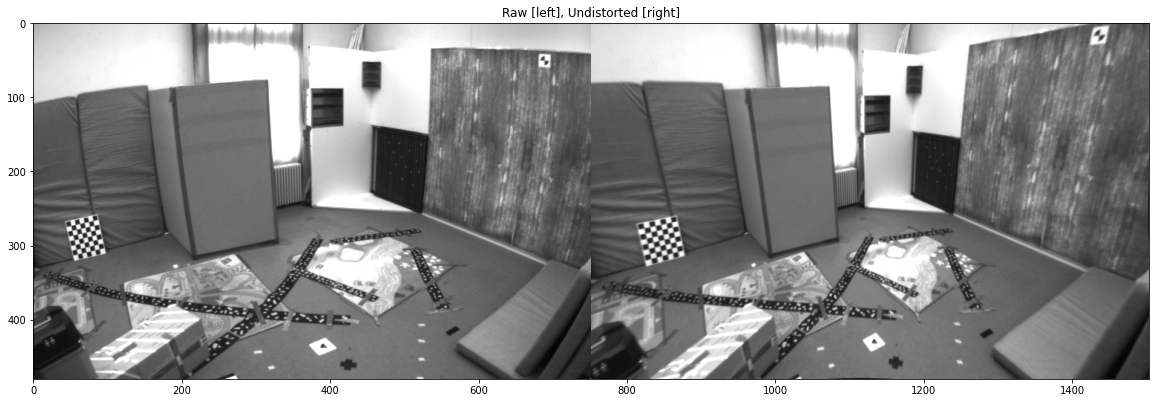

In [653]:
img = ud0.undistort(im,0)
sbs = np.hstack((im,img))
plt.imshow(sbs, cmap="gray")
plt.title("Raw [left], Undistorted [right]");

# Reprojection

In [654]:
class PLY:        
    def write(self, fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'w') as f:
            f.write(ply_header % dict(vert_num=len(verts)))
            np.savetxt(f, verts, '%f %f %f %d %d %d')

In [386]:
# stfile = "/Users/kevin/tmp/mav/mav0/cam{}/data/1403715370712143104.png"

Text(0.5, 1.0, 'Left/Right Images (465, 1504)')

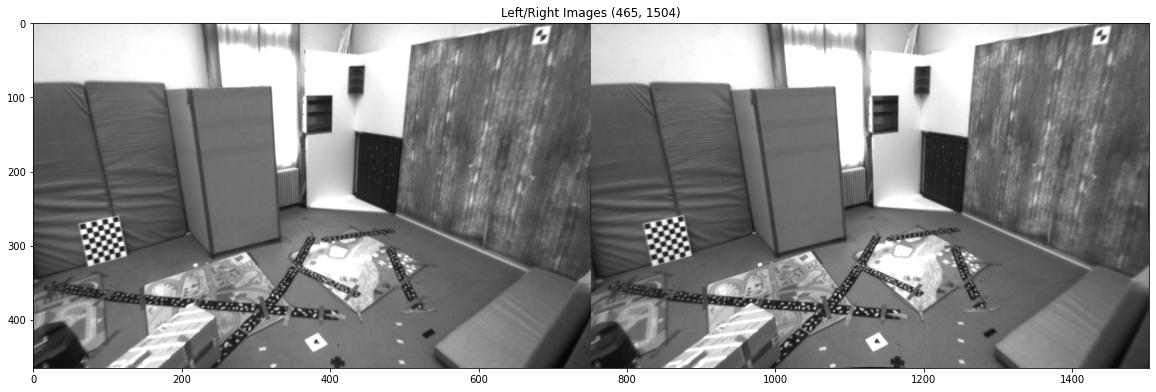

In [656]:
def getImg(num, correct):
    fname = str(Path.home() / f"tmp/mav/mav0/cam{num}/data/1403715370712143104.png")
    tmp = imageio.imread(fname)
    return correct.undistort(tmp)

imgL = getImg(0, ud0)
imgR = getImg(1, ud1)
# imgR = getImg(0, ud0) # backwards?
# imgL = getImg(1, ud1)

yoff = 15
imgL = imgL[:-yoff,:]
imgR = imgR[yoff:,:]

sbs = np.hstack((imgL, imgR))
plt.imshow(sbs, cmap="gray")
plt.title(f"Left/Right Images {sbs.shape}")
# plt.axis("equal")
# plt.axis("square")

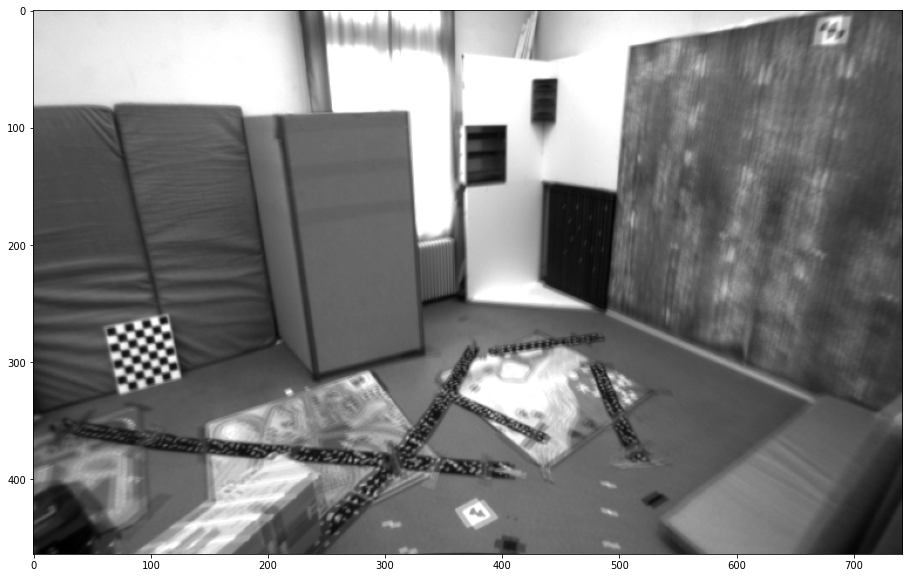

In [657]:
xoffset = 10
yoffset = 1
tmp = cv2.addWeighted(imgL[:-yoffset,:-xoffset], 0.5, imgR[yoffset:,xoffset:], 0.5,0.5)
plt.imshow(tmp, cmap="gray")

In [686]:
class Stereo2PointCloud:
    def __init__(self, baseline, focalLength, h, w):
        self.baseline = baseline
        self.f = focalLength
        self.w = w
        self.h = h
        
    def to_pc(self, imgL, imgR):
        ch = 3 # channels
        window_size = 5 # SADWindowSize
        min_disp = 16*0
        num_disp = 16*4-min_disp
#         stereo = cv2.StereoBM_create(numDisparities=96, blockSize=5)
#         stereo = cv2.StereoSGBM_create(0,64,21)
        stereo = cv2.StereoSGBM_create(
            minDisparity = min_disp,
            numDisparities = num_disp,
            blockSize = 16,          # 3-11
            P1 = 8*ch*window_size**2,
            P2 = 32*ch*window_size**2,
            disp12MaxDiff = 1,
            uniquenessRatio = 10,    # 5-15
            speckleWindowSize = 100, # 50-200
            speckleRange = 32         # 1-2
        )

        disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
#         disp = stereo.compute(imgR, imgL).astype(np.float32) / 16.0 # <<<<<<<<
        dm = (disp-min_disp)/num_disp
        
        print(f">> Computed disparity, {disp.shape} pts")
        print(f">> Disparity max: {disp.max()}, min: {disp.min()}")
        return disp, dm
        
    def reproject(self, img, disp):
        if len(img.shape) == 2:
            colors = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            colors = img
            
        t = self.baseline
        f = self.f
        Q = np.float32([[1, 0, 0, -0.5*w],
                        [0, 1, 0, -0.5*h],
                        [0, 0, 0,      f],
                        [0, 0,-1/t,    0]])
        print(Q)
    
        points = cv2.reprojectImageTo3D(disp, Q)
#         mask = disp > disp.min()  # find pts with min depth
#         mask = disp > 1
    
        points = points.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        disp = disp.reshape(-1)
        
        print(colors.shape, points.shape, disp.shape)
        
        mask = (
            (disp > disp.min()) &
            np.all(~np.isnan(points), axis=1) &
            np.all(~np.isinf(points), axis=1)
        )
        
        out_points = points[mask] # remove pts with no depth
        out_colors = colors[mask] # remove pts with no depth

        print(f'>> Generated 3d point cloud, {out_points.shape}')
        print(f">> out_points {out_points.max()}, {out_points.min()}")
        
        return out_points, out_colors

In [687]:
h,w = imgL.shape[:2]
pc = Stereo2PointCloud(baseline,458.1205,h,w)
disp, dm = pc.to_pc(imgR, imgL)
cloud, colors = pc.reproject(imgL, disp)
# print(f">> cloud pts: {cloud.shape}")
# print(f">> colors pts: {colors.shape}")

>> Computed disparity, (465, 752) pts
>> Disparity max: 48.9375, min: -1.0
[[   1.          0.          0.       -376.      ]
 [   0.          1.          0.       -232.5     ]
 [   0.          0.          0.        458.1205  ]
 [   0.          0.         -9.087115    0.      ]]
(349680, 3) (349680, 3) (349680,)
>> Generated 3d point cloud, (299101, 3)
>> out_points 59.47370910644531, -89.62541198730469


In [688]:
ply = PLY()
ply.write("out.ply", cloud, colors)

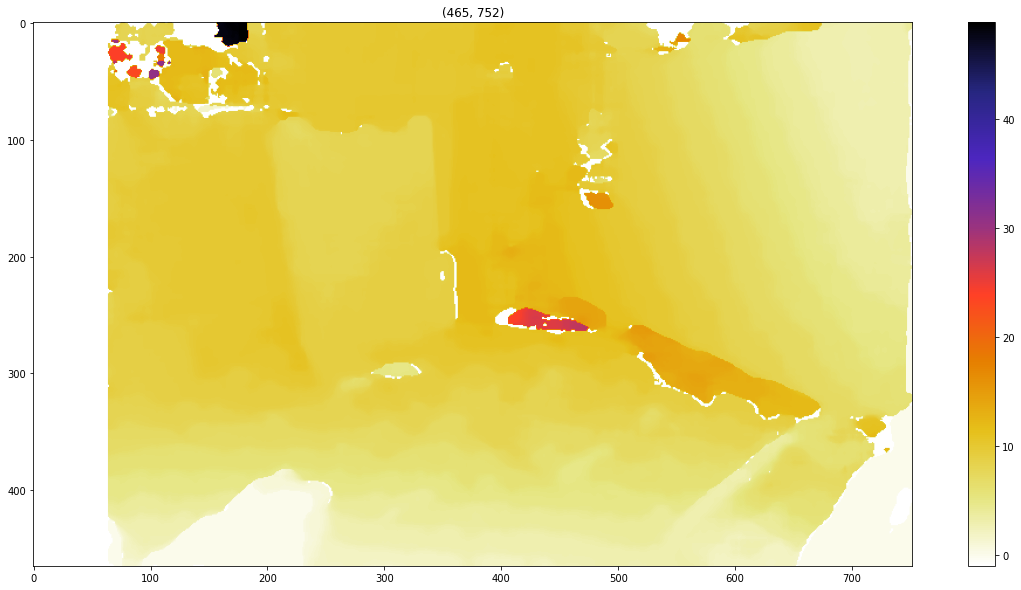

In [692]:
plt.imshow(disp, cmap="CMRmap_r")
plt.title(dm.shape)
plt.colorbar();

In [621]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d

In [625]:
# ax = plt.axes(projection='3d')
# ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2], c = colors/255, s=0.01);

In [253]:
type(disp)

numpy.ndarray

In [277]:
cloud.min()

-3.357039

In [276]:
cloud.max()

2.7584846

In [256]:
disp

array([[15.    , 15.    , 15.    , ..., 22.3125, 22.3125, 22.25  ],
       [15.    , 15.    , 15.    , ..., 22.375 , 22.3125, 22.3125],
       [15.    , 15.    , 15.    , ..., 22.4375, 22.4375, 22.375 ],
       ...,
       [15.    , 15.    , 15.    , ..., 16.    , 16.    , 16.    ],
       [15.    , 15.    , 15.    , ..., 16.    , 16.    , 16.    ],
       [15.    , 15.    , 15.    , ..., 16.    , 16.    , 16.    ]],
      dtype=float32)

In [257]:
disp.shape

(480, 752)

In [260]:
disp[0,0] = 0.0
disp[0,1] = np.nan

In [261]:
disp.min()

nan